<a href="https://www.kaggle.com/code/bhavinmoriya/markowitz-portfolio-optimization?scriptVersionId=110077302" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

We shall try to assign weights to securities (Tesla, Google, Meta, Microsoft) to optimize the return based on the given risk. All this will be done using Markowitz Portfolio Optimization, aka Modern Port. Theory, invented by Harry Markowitz. We shall do all this using two approaches,

1. Monte Carlo simulation
2. Finding out minimal -- Using SciPy 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly_express as px
import pandas_datareader as web
from datetime import datetime as dt, timedelta as td

# plt.rc\\\

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
end = dt.today()
start = end - td(days=2000)
stocks = 'GOOG TSLA META MSFT'.split()
df = web.get_data_yahoo(stocks, start, end)

In [3]:
# remove multilevel
df.columns = ['_'.join(col) for col in df.columns]

# Just study adj close 
df = df.iloc[:,:4]

In [4]:
df

,Adj Close_GOOG,Adj Close_TSLA,Adj Close_META,Adj Close_MSFT
Date,,,,
2017-05-15,NaN,21.058666,150.190002,63.594933
2017-05-16,47.150002,21.134001,149.779999,64.875443
2017-05-17,NaN,20.407333,144.850006,63.071526
2017-05-18,NaN,20.870667,147.660004,63.286495
2017-05-19,NaN,20.722000,148.059998,63.267803
...,...,...,...,...
2022-10-31,NaN,227.539993,93.160004,232.130005
2022-11-01,NaN,227.820007,95.199997,228.169998
2022-11-02,NaN,214.979996,90.540001,220.100006


In [5]:
px.line(df)

In [6]:
ret_port = df.pct_change()
px.line(ret_port)

Looks like TSLA is having jumpy ride, as you might have thought :)

In [7]:
np.random.seed(1)
# Weight each security
weights = np.random.random((4,1))
# normalize it, so that some is one
weights /= np.sum(weights)
print(f'Normalized Weights : {weights.flatten()}')

# We generally do log return instead of return
log_ret = np.log(df / df.shift(1))
log_ret

# Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
exp_ret = log_ret.mean().dot(weights)*252 
print(f'\nExpected return is : {exp_ret[0]}')

# Exp Volatility (Risk)
exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
print(f'\nVolatility : {exp_vol[0][0]}')

# Sharpe ratio
sr = exp_ret / exp_vol
print(f'\nSharpe ratio : {sr[0][0]}')

Normalized Weights : [2.89640161e-01 5.00297106e-01 7.94383512e-05 2.09983296e-01]

Expected return is : 0.43933708442672514

Volatility : 0.3790856307976798

Sharpe ratio : 1.1589389012246731


# Monte Carlo Simulation

We basically randomly initialize weights of the securities and check the returns vs risks. And among these set of weights we will find the one, for given risk, the maximum return. However, one can do all this solving optimization, using SciPy.

In [8]:
len(df.columns)

4

In [9]:
# number of simulation
n = 30_000
# n = 10

port_weights = np.zeros(shape=(n,len(df.columns)))
port_volatility = np.zeros(n)
port_sr = np.zeros(n)
port_return = np.zeros(n)

num_securities = len(df.columns)
# num_securities
for i in range(n):
    # Weight each security
    weights = np.random.random(4)
    # normalize it, so that some is one
    weights /= np.sum(weights)
    port_weights[i,:] = weights 
    #     print(f'Normalized Weights : {weights.flatten()}')

    # Expected return (weighted sum of mean returns). Mult by 252 as we always do annual calculation and year has 252 business days
    exp_ret = log_ret.mean().dot(weights)*252 
    port_return[i] = exp_ret
#     print(f'\nExpected return is : {exp_ret[0]}')

    # Exp Volatility (Risk)
    exp_vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
    port_volatility[i] = exp_vol
#     print(f'\nVolatility : {exp_vol[0][0]}')

    # Sharpe ratio
    sr = exp_ret / exp_vol
    port_sr[i] = sr
#     print(f'\nSharpe ratio : {sr[0][0]}')

In [10]:
# Index of max Sharpe Ratio
max_sr = port_sr.max()
ind = port_sr.argmax()
# Return and Volatility at Max SR
max_sr_ret = port_return[ind]
max_sr_vol = port_volatility[ind]


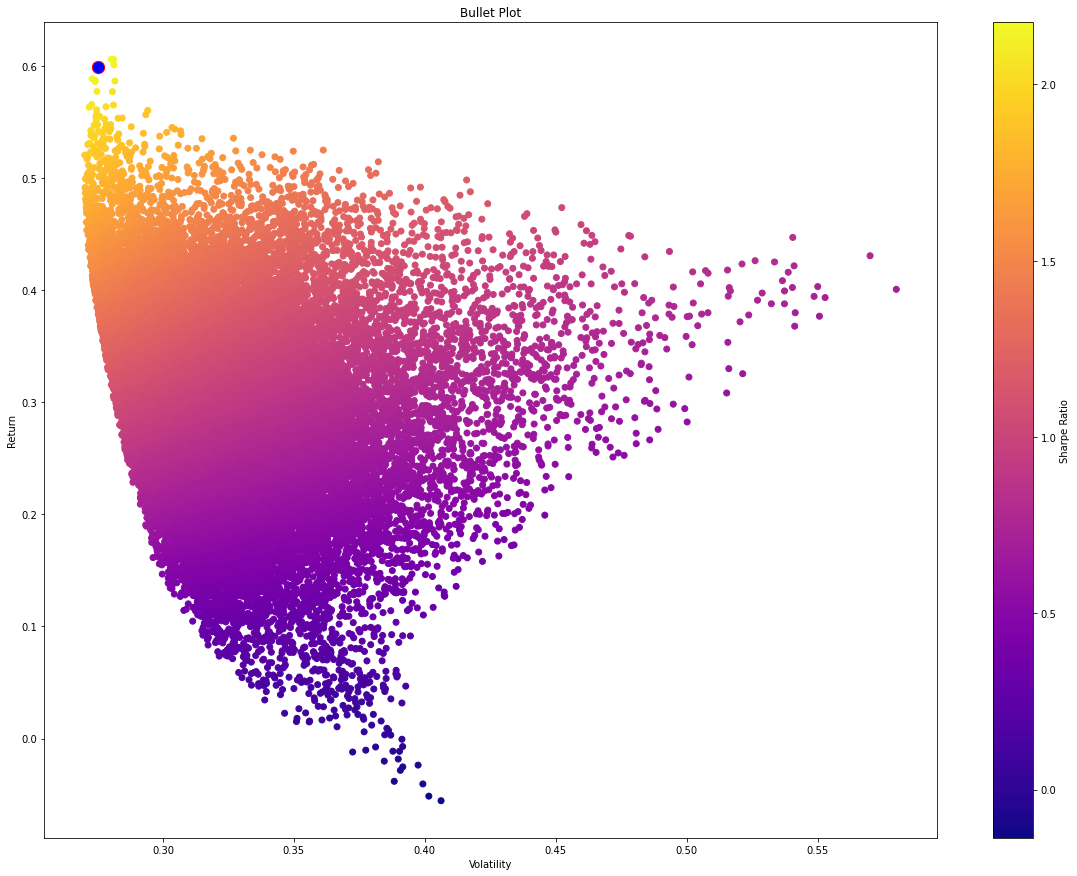

In [11]:
plt.figure(figsize=(20,15))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Bullet Plot')
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o')

All we did above can be done using optimization, which we do next.

# SciPy to get the max of Sharpe Ration

In [12]:
from scipy import optimize

In [13]:
# Some helper functions
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = log_ret.mean().dot(weights*252)
    vol = np.sqrt(weights.T.dot(252*log_ret.cov().dot(weights)))
    sr = ret / vol
    return np.array([ret, vol, sr])

# Negate Sharpe ratio as we need to max it but Scipy minimize the given function
def neg_sr(weights):
    return get_ret_vol_sr(weights)[-1] * -1

# check sum of weights 
def check_sum(weights):
    return np.sum(weights) - 1

# Constraints for the optimization problem
cons = {'type':'eq','fun':check_sum}
# bounds on weights
bounds = ((0,1),(0,1),(0,1),(0,1))
# initial guess for optimization to start with
init_guess = [.25 for _ in range(4)]


# Call minimizer
opt_results = optimize.minimize(neg_sr, init_guess, constraints=cons, bounds=bounds, method='SLSQP')


In [14]:
optimal_weights = opt_results.x
optimal_weights

array([0.95081831, 0.04918169, 0.        , 0.        ])

In [15]:
mc_weights = port_weights[ind]
mc_weights

array([0.90275062, 0.04681112, 0.00342645, 0.04701181])

In [16]:
# Comparing two results we see that we get very close results
(optimal_weights - mc_weights)

array([ 0.04806769,  0.00237057, -0.00342645, -0.04701181])

In [17]:
get_ret_vol_sr(optimal_weights), get_ret_vol_sr(mc_weights)

(array([0.61969694, 0.27668765, 2.23969862]),
 array([0.59881075, 0.27521595, 2.17578507]))

So MC and Optimizer gives very close results. MC is good but if we have many assets that it will be as expected, computing hungry, while SciPy is going to be a saviour!!!

# Frontier curve

Best return for given volatility or vice versa.

In [18]:
frontier_y = np.linspace(0,.4,100)
frontier_vol = []

def minimize_vol(weights):
    return get_ret_vol_sr(weights)[1]

for possible_ret in frontier_y:
    cons = ({'type':'eq','fun':check_sum},
            {'type':'eq','fun':lambda w:get_ret_vol_sr(w)[0] - possible_ret})
    result = optimize.minimize(minimize_vol, init_guess, method='SLSQP', constraints=cons, bounds=bounds)
    frontier_vol.append(result['fun'])    

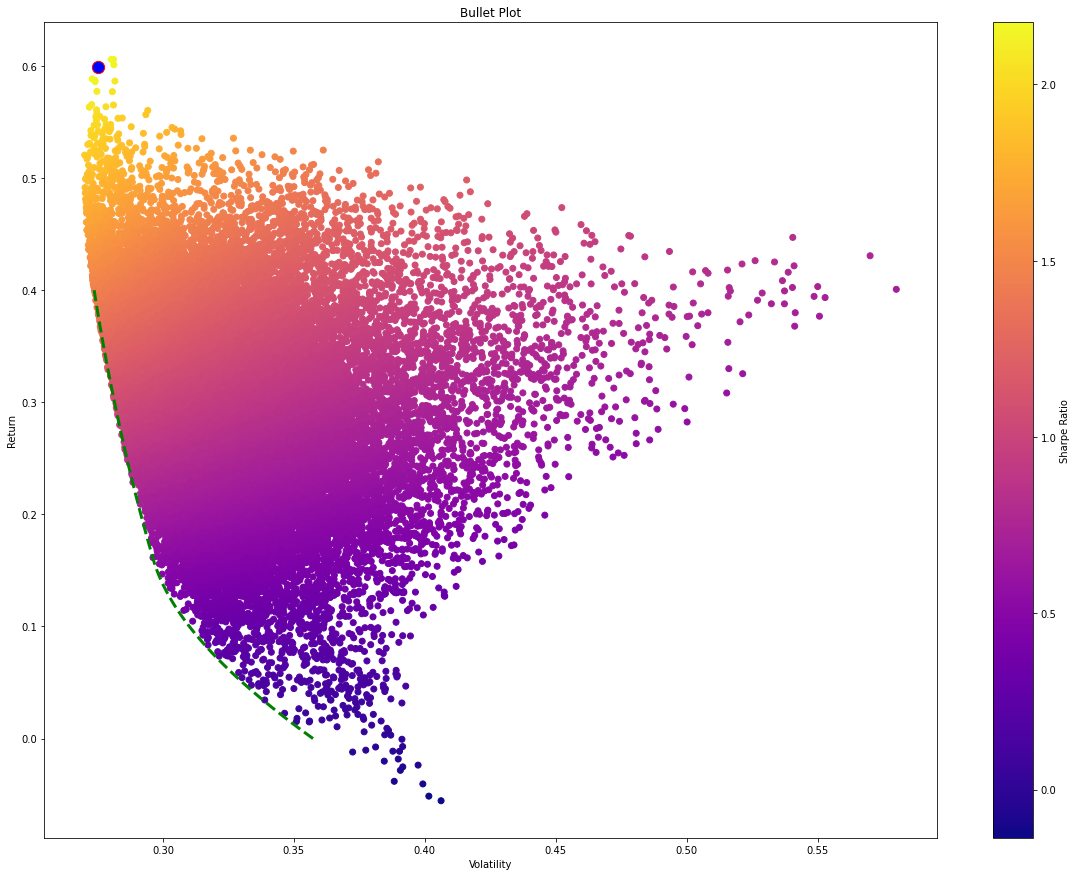

In [19]:
plt.figure(figsize=(20,15))
plt.scatter(port_volatility,port_return,c=port_sr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Bullet Plot')
plt.scatter(max_sr_vol, max_sr_ret, c='blue', s=150, edgecolors='red', marker='o')

plt.plot(frontier_vol, frontier_y, c='green', ls='--', lw=3)